In [1]:
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
import os
import os.path
from time import perf_counter

df = pd.read_csv(f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_0dte_all.csv", index_col=None, header=0)
df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
df['delta'] = df['delta'].abs()

#########################
# Settings for backtest #
#########################
delta_sp = 0.214
delta_lp = 0.178
delta_sc = None
delta_lc = None

same_day = True
purchase_time = '09:45:00'

# Max loss is % : max_loss * amount_collected is exit criteria
max_loss = 3.5

# In dollars
commission = 1.5

if same_day:
    dte_f = -1
else:
    dte_f = 0

initial_portfolio_value = 10000
    
is_spread = False
if (delta_sp is not None and delta_lp is None) or (delta_sp is not None and delta_lp is None):
    is_spread = True


In [2]:
df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
df_ty['Date'] = pd.to_datetime(df_ty['Date'])

In [3]:
def get_contract_strike(curr_date, contract_date, i_df):
    df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)].min()
    price = (df1['ask']+df1['bid'])/0.02 # 0.02 is dividing by two and multiplying by 100
    if np.isnan(price):
        return pd.Series([0,0,0])
    rounded_price = 5 * round(price / 5)
    return pd.Series([df1['strike'],df1['delta'],rounded_price])


def get_amount_lost(contract_date, strike_sp, strike_lp, strike_sc, strike_lc):
    df1 = df[(df['quote_date']==contract_date) & (df['expiration']==contract_date) & (df['quote_time']=='16:00:00')].min()
    underlying = df1['price']
    total_lost = 0.0
    if strike_sc is not None:   
        if underlying > strike_sc:
            total_lost = total_lost + (underlying - strike_sc)*100
    if strike_lc is not None:
        if underlying > strike_lc:
            total_lost = total_lost - (underlying - strike_lc)*100
    if strike_sp is not None:
        if underlying < strike_sp:
            total_lost = total_lost + (strike_sp - underlying)*100
    if strike_lp is not None:
        if underlying < strike_lp:
            total_lost = total_lost - (strike_lp - underlying)*100
    return total_lost

def get_amount_lost_minute(contract_date, strike_sp, strike_lp, strike_sc, strike_lc, curr_collected, curr_lost, curr_comm, quote_time, filtered_df):
    if curr_lost > 0.0:
        return pd.Series([curr_lost, curr_comm])
    
    if (quote_time == '16:00:00'):
        return pd.Series([get_amount_lost(contract_date, strike_sp, strike_lp, strike_sc, strike_lc), curr_comm])
    
    # TODO : change this line so quote date and expiration date can be different
    df1 = filtered_df[(filtered_df['quote_date']==contract_date) & (filtered_df['expiration']==contract_date)]
    
    if strike_sp is None:
        bb_cost_sp = 0.0
    else:
        df_sp = df1[df1['strike']==strike_sp].min()
        bb_cost_sp = (df_sp['ask']+df_sp['bid'])/0.02
    
    if strike_lp is None:
        bb_cost_lp = 0.0
    else:
        df_lp = df1[df1['strike']==strike_lp].min()
        bb_cost_lp = -1*(df_lp['ask']+df_lp['bid'])/0.02
    
    if strike_sc is None:
        bb_cost_sc = 0.0
    else:
        df_sc = df1[df1['strike']==strike_sc].min()
        bb_cost_sc = (df_sc['ask']+df_sc['bid'])/0.02
    
    if strike_lc is None:
        bb_cost_lc = 0.0
    else:
        df_lc = df1[df1['strike']==strike_lc].min()
        bb_cost_lc = -1*(df_lc['ask']+df_lc['bid'])/0.02
        
    curr_cost_to_buy_back = bb_cost_sp + bb_cost_lp + bb_cost_sc + bb_cost_lc
    # return curr_value
    if curr_cost_to_buy_back > max_loss*curr_collected:
        return pd.Series([curr_cost_to_buy_back, curr_comm*2])
    
    return pd.Series([0.0, curr_comm])

In [4]:
df_times = pd.DataFrame(df['quote_time'].unique())

df_trades = pd.DataFrame(df['expiration'].unique())
df_trades.rename({0: "expiration"}, axis='columns', inplace=True)
df_trades['trade_date'] = df_trades['expiration'].shift(1 + dte_f)
df_trades = df_trades[df_trades['trade_date'].isnull()==False]
df_trades['collected_sc'] = 0.0
df_trades['collected_lc'] = 0.0
df_trades['collected_sp'] = 0.0
df_trades['collected_lp'] = 0.0
df_trades['collected'] = 0.0
df_trades['lost'] = 0.0
df_trades['strike_sp'] = None
df_trades['strike_lp'] = None
df_trades['strike_sc'] = None
df_trades['strike_lc'] = None
df_trades['delta_sp'] = 0.0
df_trades['delta_lp'] = 0.0
df_trades['delta_sc'] = 0.0
df_trades['delta_lc'] = 0.0
df_trades['net'] = 0.0
df_trades['commission'] = 0.0
df_trades['portfolio_value'] = 0.0
df_trades['daily_return'] = 0.0
df_trades['margin_utilization']=0.0

In [5]:
trade_count = 0

# Create new filtered dataframe with only calls above target delta
if delta_sc is not None and delta_sc > 0.0:
    df_sc = df[(df['type']=="C") & (df['delta']>= delta_sc) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
    df_sc = df_sc.loc[df_sc.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Only keep the min expiration date for each quote
    df_sc = df_sc.loc[df_sc.groupby('quote_date')[['dte']].idxmin()['dte']]
    
    #apply dataframe to get strikes and collect premium
    df_trades['strike_sc'],df_trades['delta_sc'],df_trades['collected_sc'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_sc), axis = 1).T.values
    trade_count = trade_count + 1

if delta_lc is not None and delta_lc > 0.0:
    df_lc = df[(df['type']=="C") & (df['delta']>= delta_lc) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
    df_lc = df_lc.loc[df_lc.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Only keep the min expiration date for each quote
    df_lc = df_lc.loc[df_lc.groupby('quote_date')[['dte']].idxmin()['dte']]
    
    # apply dataframe to get strikes and collect premium
    df_trades['strike_lc'],df_trades['delta_lc'],df_trades['collected_lc'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_lc), axis = 1).T.values
    df_trades['collected_lc'] = df_trades['collected_lc']*-1
    trade_count = trade_count + 1

# Create new filtered dataframe with only puts above target delta
if delta_sp is not None and delta_sp > 0.0:
    df_sp = df[(df['type']=="P") & (df['delta']>= delta_sp) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so only focus on the next one
    df_sp = df_sp.loc[df_sp.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Now that we're certain we have the minimum expiration date, get the minimum delta
    df_sp = df_sp.loc[df_sp.groupby('quote_date')[['dte']].idxmin()['dte']]
    df_trades['strike_sp'],df_trades['delta_sp'],df_trades['collected_sp'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_sp), axis = 1).T.values
    trade_count = trade_count + 1

# Create new filtered dataframe with only puts above target delta
if delta_lp is not None and delta_lp > 0.0:
    df_lp = df[(df['type']=="P") & (df['delta']>= delta_lp) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so only focus on the next one
    df_lp = df_lp.loc[df_lp.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Now that we're certain we have the minimum expiration date, get the minimum delta
    df_lp = df_lp.loc[df_lp.groupby('quote_date')[['dte']].idxmin()['dte']]
    df_trades['strike_lp'],df_trades['delta_lp'],df_trades['collected_lp'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_lp), axis = 1).T.values
    df_trades['collected_lp']=df_trades['collected_lp']*-1
    trade_count = trade_count + 1

df_trades['collected'] = df_trades['collected_sc'] + df_trades['collected_lc'] + df_trades['collected_sp'] + df_trades['collected_lp']
df_trades['trade_count'] = trade_count
df_trades['commission'] = trade_count * commission

In [6]:
df_trades.head()

,expiration,trade_date,collected_sc,collected_lc,collected_sp,collected_lp,collected,lost,strike_sp,strike_lp,...,delta_sp,delta_lp,delta_sc,delta_lc,net,commission,portfolio_value,daily_return,margin_utilization,trade_count
0,2022-01-03,2022-01-03,0.0,0.0,385.0,-295.0,90.0,0.0,4775.0,4770.0,...,0.2642,0.2094,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2
1,2022-01-05,2022-01-05,0.0,0.0,350.0,-350.0,0.0,0.0,4765.0,4765.0,...,0.2192,0.2192,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2
2,2022-01-07,2022-01-07,0.0,0.0,520.0,-340.0,180.0,0.0,4680.0,4670.0,...,0.2551,0.1784,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2
3,2022-01-10,2022-01-10,0.0,0.0,605.0,-500.0,105.0,0.0,4595.0,4590.0,...,0.2388,0.2053,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2
4,2022-01-12,2022-01-12,0.0,0.0,490.0,-410.0,80.0,0.0,4700.0,4695.0,...,0.2171,0.1860,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2


In [7]:
start_time_timer = perf_counter()
for index, trow in df_times.iterrows():
    min_i = int(trow[0][3:5])
    curr_time = time(hour=int(trow[0][0:2]),minute=int(trow[0][3:5]),second=int(trow[0][6:]))
    start_time = time(hour=9, minute=45)
    end_time = time(hour=16)
    if (end_time < curr_time or curr_time <= start_time):
        continue
    filtered_df = df[(df['quote_time']==str(trow[0]))]
    df_trades['lost'], df_trades['commission'] = df_trades.apply(lambda row : get_amount_lost_minute(row['expiration'], row['strike_sp'], row['strike_lp'], row['strike_sc'], row['strike_lc'], row['collected'], row['lost'], row['commission'], str(trow[0]), filtered_df), axis=1).T.values
    
    stop_time_timer = perf_counter()
    # print(df_trades.head())
    
    if min_i % 30 == 0:
        print(f"Processed {curr_time} | Elapsed : {stop_time_timer - start_time_timer}")
        start_time_timer = stop_time_timer

Processed 10:00:00 | Elapsed : 12.154338777999783
Processed 10:30:00 | Elapsed : 24.361500951999915
Processed 11:00:00 | Elapsed : 24.31090655600019
Processed 11:30:00 | Elapsed : 24.504185632999906
Processed 12:00:00 | Elapsed : 24.34881960199982
Processed 12:30:00 | Elapsed : 24.39925365900035
Processed 13:00:00 | Elapsed : 24.310562625999864
Processed 13:30:00 | Elapsed : 24.323274135000247
Processed 14:00:00 | Elapsed : 24.41394058900005
Processed 14:30:00 | Elapsed : 24.649801683000078
Processed 15:00:00 | Elapsed : 24.485774384999786
Processed 15:30:00 | Elapsed : 24.322414453999954
Processed 16:00:00 | Elapsed : 73.95347475499966


In [8]:
df_trades['net'] = df_trades['collected'] - df_trades['lost'] - df_trades['commission']

In [9]:
df_trades['portfolio_value'] = 0.0
df_trades['daily_return'] = 0.0
df_trades['margin_utilization']=0.0
initial_portfolio_value = 10000
df_trades['net_cumsum']=df_trades['net'].cumsum()

df_trades['portfolio_value'] = initial_portfolio_value + df_trades['net_cumsum']
df_trades['transaction_return'] = df_trades['net'] / df_trades['portfolio_value'].shift(1)
df_trades['transaction_return'].iloc[0] = df_trades['net'].iloc[0] / initial_portfolio_value

df_trades['cum_return'] = (df_trades['portfolio_value'] - initial_portfolio_value) / initial_portfolio_value

df_ty['daily_risk_free_return'] = (df_ty['Adj Close'] / 252) / 100
df_ty.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

df_trades = pd.merge(df_trades, df_ty, left_on='trade_date', right_on='Date')
df_trades.drop(['Date'],axis=1,inplace=True)
df_trades.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,expiration,trade_date,collected_sc,collected_lc,collected_sp,collected_lp,collected,lost,strike_sp,strike_lp,...,net,commission,portfolio_value,daily_return,margin_utilization,trade_count,net_cumsum,transaction_return,cum_return,daily_risk_free_return
0,2022-01-03,2022-01-03,0.0,0.0,385.0,-295.0,90.0,0.0,4775.0,4770.0,...,87.0,3.0,10087.0,0.0,0.0,2,87.0,0.008700,0.0087,0.000002
1,2022-01-05,2022-01-05,0.0,0.0,350.0,-350.0,0.0,0.0,4765.0,4765.0,...,-3.0,3.0,10084.0,0.0,0.0,2,84.0,-0.000297,0.0084,0.000003
2,2022-01-07,2022-01-07,0.0,0.0,520.0,-340.0,180.0,349.0,4680.0,4670.0,...,-172.0,3.0,9912.0,0.0,0.0,2,-88.0,-0.017057,-0.0088,0.000003
3,2022-01-10,2022-01-10,0.0,0.0,605.0,-500.0,105.0,0.0,4595.0,4590.0,...,102.0,3.0,10014.0,0.0,0.0,2,14.0,0.010291,0.0014,0.000004
4,2022-01-12,2022-01-12,0.0,0.0,490.0,-410.0,80.0,0.0,4700.0,4695.0,...,77.0,3.0,10091.0,0.0,0.0,2,91.0,0.007689,0.0091,0.000005


In [10]:

                                                                                         
# if you want to scale the chart, you should do it here
factor = 1.0
df_trade_plot = df_trades.copy()
df_trade_plot['net'] = df_trade_plot['net']*factor
df_trade_plot.set_index('expiration', inplace=True)
df_trade_plot = df_trade_plot['net'].cumsum()

In [11]:
df_trades.tail(30)

,expiration,trade_date,collected_sc,collected_lc,collected_sp,collected_lp,collected,lost,strike_sp,strike_lp,...,net,commission,portfolio_value,daily_return,margin_utilization,trade_count,net_cumsum,transaction_return,cum_return,daily_risk_free_return
79,2022-06-10,2022-06-10,0.0,0.0,860.0,-655.0,205.0,484.0,3905.0,3895.0,...,-282.0,3.0,8339.0,0.0,0.0,2,-1661.0,-0.032711,-0.1661,0.000051
80,2022-06-13,2022-06-13,0.0,0.0,900.0,-705.0,195.0,0.0,3750.0,3740.0,...,192.0,3.0,8531.0,0.0,0.0,2,-1469.0,0.023024,-0.1469,0.000059
81,2022-06-14,2022-06-14,0.0,0.0,825.0,-610.0,215.0,0.0,3700.0,3690.0,...,212.0,3.0,8743.0,0.0,0.0,2,-1257.0,0.024851,-0.1257,0.000069
82,2022-06-15,2022-06-15,0.0,0.0,1225.0,-930.0,295.0,0.0,3715.0,3700.0,...,292.0,3.0,9035.0,0.0,0.0,2,-965.0,0.033398,-0.0965,0.000067
83,2022-06-16,2022-06-16,0.0,0.0,835.0,-615.0,220.0,0.0,3640.0,3630.0,...,217.0,3.0,9252.0,0.0,0.0,2,-748.0,0.024018,-0.0748,0.000059
84,2022-06-17,2022-06-17,0.0,0.0,815.0,-625.0,190.0,0.0,3655.0,3645.0,...,187.0,3.0,9439.0,0.0,0.0,2,-561.0,0.020212,-0.0561,0.000060
85,2022-06-21,2022-06-21,0.0,0.0,620.0,-530.0,90.0,0.0,3715.0,3710.0,...,87.0,3.0,9526.0,0.0,0.0,2,-474.0,0.009217,-0.0474,0.000059
86,2022-06-22,2022-06-22,0.0,0.0,650.0,-550.0,100.0,0.0,3700.0,3695.0,...,97.0,3.0,9623.0,0.0,0.0,2,-377.0,0.010183,-0.0377,0.000061
87,2022-06-23,2022-06-23,0.0,0.0,645.0,-540.0,105.0,0.0,3745.0,3740.0,...,102.0,3.0,9725.0,0.0,0.0,2,-275.0,0.010600,-0.0275,0.000062
88,2022-06-24,2022-06-24,0.0,0.0,620.0,-530.0,90.0,0.0,3815.0,3810.0,...,87.0,3.0,9812.0,0.0,0.0,2,-188.0,0.008946,-0.0188,0.000063


In [12]:
def net2pct(x):
    return (x / initial_portfolio_value)*100


def pct2net(x):
    return initial_portfolio_value * x/100



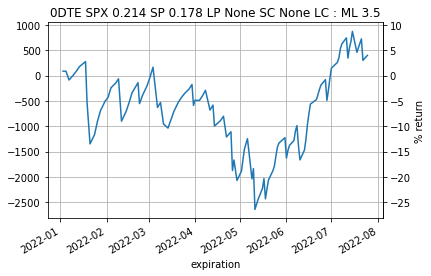

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
secax = ax.secondary_yaxis('right', functions=(net2pct, pct2net))
secax.set_ylabel('% return')
df_trade_plot.plot(ax=ax)
plt.title(f"{'0' if same_day else '1-2'}DTE SPX {delta_sp} SP {delta_lp} LP {delta_sc} SC {delta_lc} LC : ML {max_loss}")
plt.grid()
plt.savefig(f"{'0' if same_day else '1-2'}DTE_SPX_{delta_sp}SP_{delta_lp}LP_{delta_sc}SC_{delta_lc}LC_IC.png")

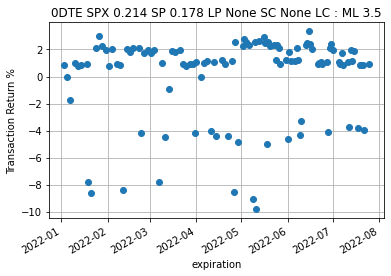

In [14]:
df_trades_transaction_return = df_trades.copy()
df_trades_transaction_return['transaction_return'] *= 100 
df_trades_transaction_return.set_index('expiration', inplace=True)
fig = plt.figure()
ax = df_trades_transaction_return['transaction_return'].plot(linestyle='None', marker="o")
ax.set_ylabel('Transaction Return %')
plt.title(f"{'0' if same_day else '1-2'}DTE SPX {delta_sp} SP {delta_lp} LP {delta_sc} SC {delta_lc} LC : ML {max_loss}")
plt.grid()
plt.savefig(f"{'0' if same_day else '1-2'}DTE_SPX_{delta_sp}SP_{delta_lp}LP_{delta_sc}SC_{delta_lc}LC_IC.png")

In [15]:
trade_count = df_trades.shape[0]
win_count = df_trades[df_trades['net']>0].shape[0]
loss_count = df_trades[df_trades['net']<0].shape[0]
std_trans_return = df_trades['transaction_return'].std()
std_trans_return_less_rf = (df_trades['transaction_return'] - df_trades['daily_risk_free_return']).std()
print("*****  BACKTEST RESULTS  ****")
print(
    f"\n{'Cumulative return:':<35}{round(df_trades['cum_return'].iloc[-1]*100,3):>10} %",
    f"\n{'Max Drawdown:':<35}{round(df_trades['cum_return'].min()*100,3):>10} %",
    
    f"\n{'Trades:':<35}{trade_count:>10}",
    f"\n{'Wins:':<35}{win_count:>10}",
    f"\n{'Losses:':<35}{loss_count:>10}",
    f"\n{'Breakeven:':<35}{df_trades[df_trades['net']==0.0].shape[0]:>10}",
    f"\n{'Win/Loss Ratio:':<35}{round(win_count/trade_count*100,3):>10} %",
    f"\n{'Mean Win:':<35}{round(df_trades[df_trades['net']>0]['net'].mean(),3):>10} $",
    f"\n{'Mean Win Trans Return:':<35}{round(df_trades[df_trades['transaction_return']>0]['transaction_return'].mean()*100,3):>10} %",
    f"\n{'Mean Loss:':<35}{round(df_trades[df_trades['net']<0]['net'].mean(),3):>10} $",
    f"\n{'Mean Loss Trans Return:':<35}{round(df_trades[df_trades['transaction_return']<0]['transaction_return'].mean()*100,3):>10} %",
    f"\n{'Mean Net Trans:':<35}{round(df_trades['net'].mean(),3):>10} $",
    f"\n{'Mean Trans Return:':<35}{round(df_trades['transaction_return'].mean()*100,3):>10} %",
    f"\n{'Std Dev of Net Trans:':<35}{round(df_trades['net'].std(),3):>10}",
    f"\n{'Std Dev of Trans Return:':<35}{round(df_trades['transaction_return'].std(),3):>10}",
    f"\n{'Max Loss:':<35}{round(df_trades['net'].min(),3):>10} $",
    f"\n{'Max Win:':<35}{round(df_trades['net'].max(),3):>10} $",
    f"\n{'Sharpe Ratio static STD:':<35}{round(np.sqrt(252)*(df_trades['transaction_return'].mean()-df_trades['daily_risk_free_return'].mean())/std_trans_return,3):>10}",
    f"\n{'Sharpe Ratio with RF STD:':<35}{round(np.sqrt(252)*(df_trades['transaction_return'].mean()-df_trades['daily_risk_free_return'].mean())/std_trans_return_less_rf,3):>10}",

)



*****  BACKTEST RESULTS  ****

Cumulative return:                       3.97 % 
Max Drawdown:                          -26.37 % 
Trades:                                   109 
Wins:                                      83 
Losses:                                    26 
Breakeven:                                  0 
Win/Loss Ratio:                        76.147 % 
Mean Win:                             147.482 $ 
Mean Win Trans Return:                  1.631 % 
Mean Loss:                           -455.538 $ 
Mean Loss Trans Return:                -4.848 % 
Mean Net Trans:                         3.642 $ 
Mean Trans Return:                      0.086 % 
Std Dev of Net Trans:                 288.306 
Std Dev of Trans Return:                0.031 
Max Loss:                              -833.0 $ 
Max Win:                                292.0 $ 
Sharpe Ratio static STD:                0.417 
Sharpe Ratio with RF STD:               0.417
